In [1]:
import polars as pl
from preprocess.polars_helpers import *

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [3]:
swap_df_usdc = filter_swap_pairs(df_filepaths, 'WETH', 18, 'USDC', 6)
swap_df_usdt = filter_swap_pairs(df_filepaths, 'WETH', 18, 'USDT', 6)
# binance has pegged tokens and they both have 18 decimals
swap_df_eth = filter_swap_pairs(df_filepaths, 'ETH', 18, 'USDC', 18)

In [4]:
swap_df = pl.concat([swap_df_usdc, swap_df_usdt, swap_df_eth])

In [5]:
# filter out outlier values that are too large or too small. We get weird values probably due precision rounding errors because values are stored as float64s
filter_swap_df = swap_df.filter((pl.col("executionPrice") < 2500) & (pl.col("executionPrice") > 1000))

# second filter for transactions larger than $1 USD
filter_swap_df = filter_swap_df.filter((pl.col("amountInUSD") > 1) & (pl.col("amountOutUSD") > 1))

In [6]:
filter_swap_df.shape

(6431715, 14)

In [7]:
spot_df = filter_swap_df.select([
    'timestamp',
    pl.col('executionPrice').alias('price'),
    'blockchain'
])

In [8]:
# group by timestamp and blockchain and average 'price' over same timestamps
spot_df = spot_df.groupby(['timestamp', 'blockchain']).mean()

### Oracle Prices


In [9]:
chain_df = pl.read_parquet('data/price/chainlink_eth_price.parquet')
pyth_df = pl.read_csv('data/price/pyth_eth_prices.csv')

In [10]:
chain_df = chain_df.select([
    'timestamp',
    'price',
    'blockchain'
])

# select a subset of pyth_df columns
pyth_df = pyth_df.select([
    'time',
    'price',
    'cluster'
])

In [11]:
# rename pyth columns
pyth_df = pyth_df.rename({"time": "timestamp", "cluster": "blockchain"})

# convert timestamp to datetime
pyth_df = pyth_df.with_columns(
   pl.col("timestamp").str.to_datetime("%Y-%m-%d %H:%M:%S")
)

In [12]:
print(f'chainlink: {chain_df.shape}, pythnet: {pyth_df.shape}')

chainlink: (4869, 3), pythnet: (1011990, 3)


### Create Price Oracle Index

In [13]:
# get min timestamp value for chain_df
min_timestamp = chain_df.select(pl.min("timestamp")).min().item()
# get max timestamp value for chain_df
max_timestamp = chain_df.select(pl.max("timestamp")).max().item()

In [14]:
print(min_timestamp, max_timestamp)

2023-03-01 05:22:47 2023-05-30 03:55:35


In [15]:
# create an empty polars series with the timestamp range
price_index = pl.date_range(min_timestamp, max_timestamp, interval='1s', eager=True).alias("timestamp")

# change price_index into a dataframe
price_index = price_index.to_frame("timestamp")

In [16]:
# left join chain_df
chain_reindexed = price_index.join(chain_df, on='timestamp', how='left')
# left join python_df
pyth_reindexed = price_index.join(pyth_df, on='timestamp', how='left')
# deal with duplicate timestamps by taking the mean
pyth_reindexed = pyth_reindexed.groupby(['timestamp', 'blockchain']).mean()
# reorder columns
pyth_reindexed = pyth_reindexed.select([
    'timestamp',
    'price',
    'blockchain'
])

# sort pyth_reindexed
pyth_reindexed = pyth_reindexed.sort('timestamp', descending=False)

In [17]:
# get unique list of spot_df blockchains
blockchain_list = spot_df.select(pl.col('blockchain')).unique().to_series().to_list()

In [18]:
spot_dataframes = []

In [19]:
for blockchain in blockchain_list:
    # filter by blockchain
    spot_blockchain_df = spot_df.filter(pl.col('blockchain') == blockchain)
    # left join spot_blockchain_df
    spot_reindexed = price_index.join(spot_blockchain_df, on='timestamp', how='left')
    # fill in missing values with previous value
    spot_reindexed = spot_reindexed.select(pl.all().forward_fill())
    # reorder columns
    spot_reindexed = spot_reindexed.select(['timestamp', 'price', 'blockchain'])
    spot_dataframes.append(spot_reindexed)

In [20]:
# forward fill values
chain_reindexed = chain_reindexed.select(pl.all().forward_fill())
pyth_reindexed = pyth_reindexed.select(pl.all().forward_fill())

In [21]:
# concat together
final_price_df = pl.concat([chain_reindexed, pyth_reindexed, *spot_dataframes])

In [22]:
# get values where blockchain= pythnet
# final_price_df.filter(pl.col('blockchain') == 'pythnet')

In [23]:
pivot_df = final_price_df.pivot(
    index="timestamp",
    columns="blockchain",
    values="price",
    aggregate_function=pl.col('price').mean()
)

In [24]:
# drop null column
pivot_df = pivot_df.drop("null")

### Plotting

In [25]:
# convert to pandas
pivot_df_pandas = pivot_df.to_pandas()

In [26]:
pivot_df_pandas.head(25)

,timestamp,chainlink,pythnet,optimism,ethereum,bsc,arbitrum,polygon
0,2023-03-01 05:22:47,1650.407264,NaN,NaN,1650.803389,NaN,NaN,NaN
1,2023-03-01 05:22:48,1650.407264,NaN,NaN,1650.803389,NaN,NaN,NaN
2,2023-03-01 05:22:49,1650.407264,NaN,NaN,1650.803389,NaN,NaN,NaN
3,2023-03-01 05:22:50,1650.407264,NaN,NaN,1650.803389,NaN,NaN,NaN
4,2023-03-01 05:22:51,1650.407264,NaN,NaN,1650.803389,NaN,NaN,NaN
5,2023-03-01 05:22:52,1650.407264,NaN,NaN,1650.803389,NaN,NaN,NaN
6,2023-03-01 05:22:53,1650.407264,NaN,NaN,1650.803389,NaN,1650.155954,1651.967148
7,2023-03-01 05:22:54,1650.407264,NaN,NaN,1650.803389,NaN,1650.155954,1651.967148
8,2023-03-01 05:22:55,1650.407264,NaN,NaN,1650.803389,NaN,1650.155954,1651.967148
9,2023-03-01 05:22:56,1650.407264,NaN,NaN,1650.803389,NaN,1650.155954,1651.967148


In [27]:
# copy pivot df
price_deviation_df = pivot_df_pandas.copy(deep=True)

In [28]:
# add columns for price deviation
price_deviation_df['arbitrum'] = (price_deviation_df['arbitrum'] - price_deviation_df['chainlink']) / price_deviation_df['chainlink'] * 10000
price_deviation_df['bsc'] = (price_deviation_df['bsc'] - price_deviation_df['chainlink']) / price_deviation_df['chainlink']  * 10000
price_deviation_df['ethereum'] = (price_deviation_df['ethereum'] - price_deviation_df['chainlink']) / price_deviation_df['chainlink']  * 10000
price_deviation_df['optimism'] = (price_deviation_df['optimism'] - price_deviation_df['chainlink']) / price_deviation_df['chainlink']  * 10000
price_deviation_df['polygon'] = (price_deviation_df['polygon'] - price_deviation_df['chainlink']) / price_deviation_df['chainlink']  * 10000
price_deviation_df['pythnet'] = (price_deviation_df['pythnet'] - price_deviation_df['chainlink']) / price_deviation_df['chainlink']  * 10000

In [29]:
price_deviation_df.head(10)

,timestamp,chainlink,pythnet,optimism,ethereum,bsc,arbitrum,polygon
0,2023-03-01 05:22:47,1650.407264,NaN,NaN,2.400163,NaN,NaN,NaN
1,2023-03-01 05:22:48,1650.407264,NaN,NaN,2.400163,NaN,NaN,NaN
2,2023-03-01 05:22:49,1650.407264,NaN,NaN,2.400163,NaN,NaN,NaN
3,2023-03-01 05:22:50,1650.407264,NaN,NaN,2.400163,NaN,NaN,NaN
4,2023-03-01 05:22:51,1650.407264,NaN,NaN,2.400163,NaN,NaN,NaN
5,2023-03-01 05:22:52,1650.407264,NaN,NaN,2.400163,NaN,NaN,NaN
6,2023-03-01 05:22:53,1650.407264,NaN,NaN,2.400163,NaN,-1.522718,9.451509
7,2023-03-01 05:22:54,1650.407264,NaN,NaN,2.400163,NaN,-1.522718,9.451509
8,2023-03-01 05:22:55,1650.407264,NaN,NaN,2.400163,NaN,-1.522718,9.451509
9,2023-03-01 05:22:56,1650.407264,NaN,NaN,2.400163,NaN,-1.522718,9.451509


In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [31]:
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'{value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return f'{value:.0f}'

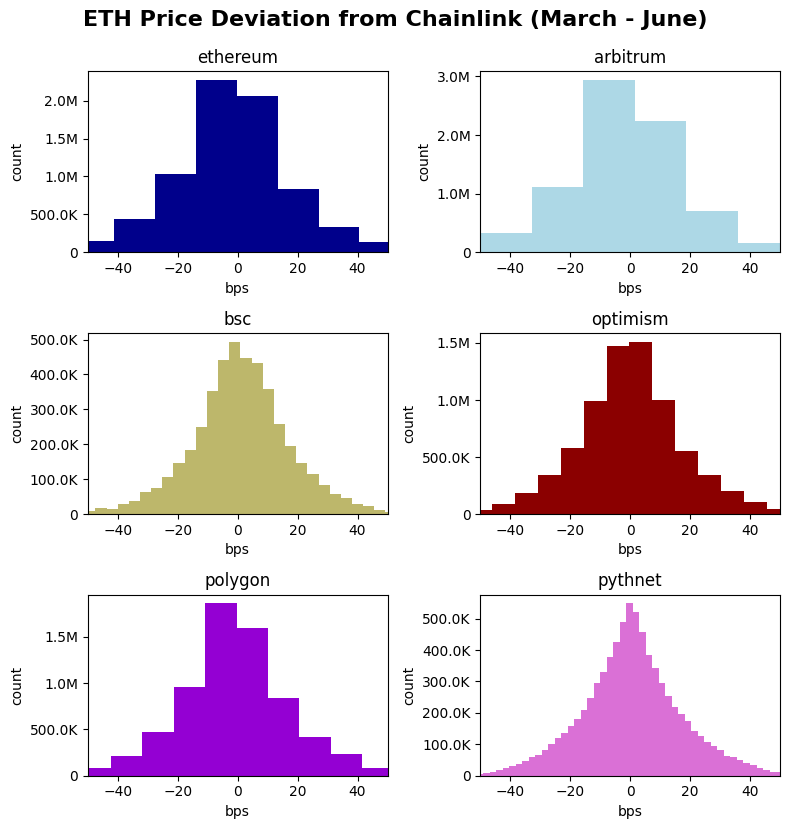

In [35]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

# Define the data and labels for each histogram
data = {
    'ethereum': price_deviation_df['ethereum'],
    'arbitrum': price_deviation_df['arbitrum'],
    'polygon': price_deviation_df['polygon'],
    'optimism': price_deviation_df['optimism'],
    'bsc': price_deviation_df['bsc'],
    'pythnet': price_deviation_df['pythnet']
}

labels = ['ethereum', 'arbitrum', 'bsc', 'optimism', 'polygon', 'pythnet']
colors = ['darkblue', 'lightblue', 'darkkhaki', 'darkred', 'darkviolet', 'orchid']


# Iterate over the subplots and create histograms
for i, ax in enumerate(axs.flat):
    if i < len(labels):
        ax.hist(data[labels[i]], bins=250, color=colors[i].format(i))
        ax.set_title(labels[i])

        # Set common x and y axis limits
        ax.set_xlim(-50, 50)
        ax.set_xlabel('bps')
        ax.set_ylabel('count')
        # set y axis formatter
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

    # no empty subplots to remove
    # else:
    #     fig.delaxes(ax)

# Adjust the spacing between subplots
plt.tight_layout()

# Add a main title
fig.suptitle('ETH Price Deviation from Chainlink (March - June)', fontsize=16, fontweight='bold', y=1.03)

# Show the plot
plt.show()

# save picture
fig.savefig('charts/eth_price_deviation_chain.png', dpi=300, bbox_inches='tight')